# Estimating parameters of the Hodgkin-Huxley model by using ResNet(FCN)
#### $\begin{equation*}I_{Kr}=g_{Kr}ar(V-E_K)\end{equation*}$
#### $\begin{equation*}E_K=\frac{RT}{zF}\ln{(\frac{[K^+]_o}{[K^+]_i})} \end{equation*}$
#### $\begin{equation*}\frac{da}{dt}=\frac{a_{\infty}-a}{\tau_a}, \frac{dr}{dt}=\frac{r_{\infty}-r}{\tau_r} \end{equation*}$
#### $\begin{equation*}a_{\infty}=\frac{k_1}{k_1+k_2}, r_{\infty}=\frac{k_4}{k_3+k_4}\end{equation*}$
#### $\begin{equation*}\tau_{a}=\frac{1}{k_1+k_2}, \tau_{r}=\frac{1}{k_3+k_4}\end{equation*}$
where
#### $\begin{equation*} k_1 = p_1\exp(p_2V) \end{equation*}$
#### $\begin{equation*} k_2 = p_3\exp(-p_4V) \end{equation*}$
#### $\begin{equation*} k_3 = p_5\exp(p_6V) \end{equation*}$
#### $\begin{equation*} k_4 = p_7\exp(-p_8V) \end{equation*}$
#### Estimating 9 Parameters : $[g_{Kr},\ p_1,\ p_2,\ p_3,\ p_4,\ p_5,\ p_6,\ p_7,\ p_8]$

In [1]:
import os, sys, copy
import time
sys.path.append('../')

import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
#from parallel import DataParallelModel, DataParallelCriterion

from typing import Type, Any, Callable, Union, List, Optional

from IPython.display import HTML
from IPython import display

import numpy as np
import random
import matplotlib.pyplot as plt

from datetime import datetime
import pandas as pd
import seaborn as sns


import librosa
import librosa.display

import cv2
import skimage.io


# seed 값 생성
random.seed(3)
np.random.seed(3)
torch.manual_seed(3)

sys.path.append('../../JKLib')
from pythonJK import create_folder
from torchJK import CosineAnnealingWarmUpRestarts, PositionalEncoding, PositionalEmbedding
from metricJK import MSE, cosine_similarity

from model0 import TransformerION
dataset_dir = '../../Dataset/ohara2017_leemV1_w1_s1'
sys.path.append(dataset_dir)
from agetdata import get_dataset

print(torch.__version__)

1.10.2+cu113


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
if (device.type == 'cuda') and (torch.cuda.device_count() >1):
    print("Multi GPU activate")
# device = 'cpu'

Multi GPU activate


In [3]:
BATCH_SIZE = 512
test_dataset_li = list(range(26, 31))
models_dir = "./trained_model0_ohara2017_leemV1_w1_s1"
model_file_path = os.path.join(models_dir, 'params-700.pk')
output_dir1 = f'./{models_dir}/Results1_sim'        
create_folder(output_dir1)
output_dir2 = f'./{models_dir}/Results2_sim'     
create_folder(output_dir2)

# Parameters for trained_model1
d_model = 512    # default : 512
nhead = 8    # default : 8
num_encoder_layers = 3  # default : 6
dim_feedforward = 2048   # default : 2048
n_parameters = 7

G_adj_li = ['ina.g_adj', 'inal.g_adj', 'ito.g_adj', 'ical.g_adj', 'ikr.g_adj', 'iks.g_adj', 'ik1.g_adj']#, 'Gffc' ]

"././trained_model0_ohara2017_leemV1_w1_s1/Results1_sim" has been created.
"././trained_model0_ohara2017_leemV1_w1_s1/Results2_sim" has been created.


In [4]:
'''
Load time, Christini Voltage Calmp ,currents and parameters
'''
start_time = time.time()
x_test, y_test = get_dataset( test_dataset_li, multi=False, use_torch=True )
x_test = x_test.type(torch.float)
y_test = y_test.type(torch.float)
print(x_test.shape, y_test.shape)
print("--- %s seconds ---"%(time.time()-start_time))

--- 2.1043238639831543 seconds ---
torch.Size([50000, 7, 1320]) torch.Size([50000, 7])
--- 2.9144818782806396 seconds ---


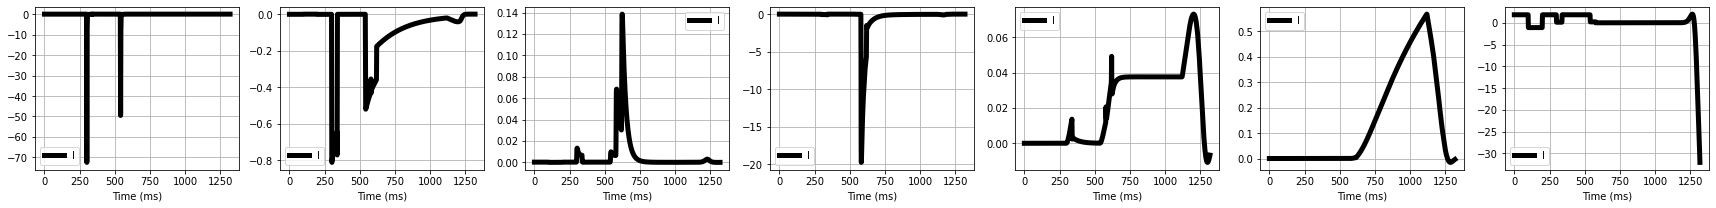

In [5]:
'''
Plot
'''
currents = x_test[0]

fig, ax = plt.subplots(1,7, figsize=(30,3))    
# fig.suptitle(sim.name, fontsize=14)
axNo = 0
for i, val in enumerate(currents):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[axNo].set_xlabel('Time (ms)')       
    # ax[axNo].set_ylabel(f'{name}')      
    ax[axNo].plot( val, label='I', color='k', linewidth=5)             
    ax[axNo].legend()
    ax[axNo].grid()
    axNo += 1

# ax[-1].set_ylim(-5, 5)
# plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
# fig.savefig(os.path.join('Results', "C.jpg"), dpi=100)

In [6]:
from torch.utils.data import  TensorDataset, DataLoader
test_ds = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [7]:
print(test_ds[0][0].shape, test_ds[0][1].shape)

torch.Size([7, 1320]) torch.Size([7])


In [8]:
model = TransformerION(num_encoder_layers = num_encoder_layers,
                       d_model = d_model,
                       nhead = nhead,
                       dim_feedforward = dim_feedforward,
                       n_parameters = n_parameters)

In [9]:
checkpoint = torch.load(model_file_path) 
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Best MSE for train dataset
1 : (697, 0.000015)
2 : (692, 0.000015)
3 : (690, 0.000015)
4 : (688, 0.000015)
5 : (698, 0.000015)
6 : (685, 0.000015)
7 : (699, 0.000015)
8 : (681, 0.000015)
9 : (700, 0.000015)
10 : (686, 0.000015)
Best MSE for validation dataset
1 : (148, 0.000047)
2 : (201, 0.000048)
3 : (132, 0.000051)
4 : (206, 0.000057)
5 : (187, 0.000061)
6 : (177, 0.000066)
7 : (165, 0.000067)
8 : (469, 0.000068)
9 : (224, 0.000072)
10 : (440, 0.000072)
0.47387380953188296 1.4635447533456264e-05
0.4537571801079644 4.693181512670385e-05


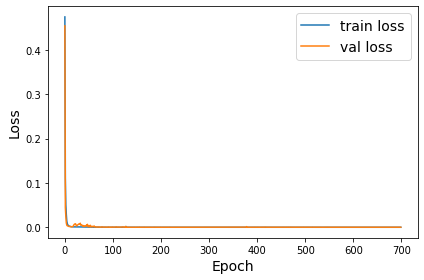

0.00015546722958485285

In [10]:
train_loss_arr = np.array(checkpoint['train_loss_li'])
train_best_epoch = train_loss_arr.argsort() + 1
print("Best MSE for train dataset")
for i, epoch in enumerate(train_best_epoch[:10]):
    print("%d : (%d, %f)"%(i+1, epoch, train_loss_arr[epoch-1]))

print("="*50)

print("Best MSE for validation dataset")
val_loss_arr = np.array(checkpoint['val_loss_li'])
val_best_epoch = val_loss_arr.argsort() + 1
for i, epoch in enumerate(val_best_epoch[:10]):
    print("%d : (%d, %f)"%(i+1, epoch, val_loss_arr[epoch-1]))

print(train_loss_arr.max(), train_loss_arr.min())
print(val_loss_arr.max(), val_loss_arr.min())
# plt.title("Loss", fontsize=18) 
plt.xlabel( "Epoch", fontsize=14)
plt.ylabel( "Loss", fontsize=14)
# plt.ylim(0, 0.05)
plt.plot(checkpoint['train_loss_li'], label='train loss')
plt.plot(checkpoint['val_loss_li'], label='val loss')
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig( os.path.join(output_dir1, 'train_val_loss.jpg'), dpi=199) 
plt.show()
checkpoint['val_loss_li'][-1]

In [11]:
def test(model, data_loader):       
    loss_sum = 0    
    criterion = nn.MSELoss()
    result_li = []        
    nIter = 0    
    with torch.no_grad():            
        model.eval() 
        for i, data in enumerate(data_loader):  
            X = data[0].to(device)
            Y = data[1].to(device)
            output = model(X)    
            
            output[output<0] = 0.
            output[output>1] = 1.            
            
            loss = criterion(output, Y)
            loss_sum += loss.cpu().item()          
            
#             loss = MSE(output.cpu().detach().numpy(), Y.cpu().detach().numpy() )            
#             loss_sum += loss.sum()/8
                        
            result_li.append(output)            
            nIter+=1
     
    return loss_sum/nIter, torch.cat(result_li).cpu().detach().numpy() 


In [12]:
final_model_file = None
final_model = None
final_loss = float('inf')
final_results = None

file_li = os.listdir(models_dir)
# modelNo_li = list(range(333, 334)) #list(range(11, 366)) val_loss_argsort
modelNo_li = val_best_epoch[:5]


test_loss_li = []
for epoch in modelNo_li:#len(file_li)+1):
   
    start_time = time.time()
    model_file = "params-%d.pk"%(epoch)    
    checkpoint = torch.load(os.path.join(models_dir, model_file ) )       ## Why is this getting slower?
    #checkpoint = torch.load(path, map_location=lambda storage, loc: storage)

    model.load_state_dict(checkpoint['model_state_dict'])                    
    model.to(device)

    loss, results  = test(model, test_loader)    
    test_loss_li.append((epoch, loss))
    if loss<final_loss:
        final_model_file = model_file
        final_model = model
        final_loss = loss
        final_results = results

    print("Loss for %s : %f"%(model_file, loss ) )
    print("--- %s seconds ---"%(time.time()-start_time))

# print("--- %s seconds ---"%(time.time()-start_time))

print("="*50)
print("Final model : %s"%(final_model_file))
print("Loss for test dataset :", final_loss)

Loss for params-148.pk : 0.000239
--- 18.963572025299072 seconds ---
Loss for params-201.pk : 0.000277
--- 18.966175317764282 seconds ---
Loss for params-132.pk : 0.000293
--- 19.065447568893433 seconds ---
Loss for params-206.pk : 0.000269
--- 19.217450618743896 seconds ---
Loss for params-187.pk : 0.000256
--- 18.732476711273193 seconds ---
Final model : params-148.pk
Loss for test dataset : 0.00023946792873398315


MSE for test dataset
1 : (148, 0.000239)
2 : (187, 0.000256)
3 : (206, 0.000269)
4 : (201, 0.000277)
5 : (132, 0.000293)


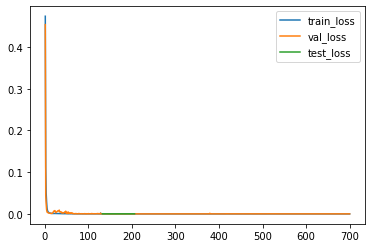

In [13]:
test_loss_arr = np.array(test_loss_li)
test_loss_sort = test_loss_arr[:, 1].argsort()
print("MSE for test dataset")
for i, epoch in enumerate(test_loss_sort[:5]):
    print("%d : (%d, %f)"%(i+1, test_loss_li[epoch][0], test_loss_li[epoch][1]))

test_loss_epoch_sort = test_loss_arr[test_loss_arr[:, 0].argsort()]

# aa = np.hstack([val_loss_arr, test_loss_arr])
plt.plot(np.arange(1, len(train_loss_arr)+1) , train_loss_arr, label='train_loss')    
plt.plot(np.arange(1, len(val_loss_arr)+1) , val_loss_arr, label='val_loss')
plt.plot(test_loss_epoch_sort[:, 0] , test_loss_epoch_sort[:, 1], label='test_loss')
plt.legend()
plt.show()

In [14]:
y_test.cpu().numpy().shape

(50000, 7)

In [15]:
targets = y_test.cpu().numpy()

In [16]:
import sklearn 
import scipy.stats as stats

mse_li = []
for i in range(final_results.shape[0]):
#     print(stats.pearsonr(y_test[i], final_results[i]))
#     print(y_test[i, 8], final_results[i, 8])    
    mse = MSE(targets[i], final_results[i], axis=0)
    mse_li.append(mse)
mse_li = np.array(mse_li)
    
#     pearson = stats.pearsonr(y_test[i], final_results[i])
#     pearson1 = stats.pearsonr(real_parameter[i], predicted_parameter[i])
# #     pearson2 = np.corrcoef(y_test[i], final_results[i])
        
#     cos_sim = cosine_similarity(y_test[i], final_results[i])
#     cos_sim1 = cosine_similarity(real_parameter[i], predicted_parameter[i])
    
#     if pearson[0] <= 1:     
#         print("mse : %f"%(mse))
#         print("pearson : %f, p-value : %f"%(pearson[0], pearson[1]))
#         print("pearson : %f, p-value : %f"%(pearson1[0], pearson1[1]))
# #         print(pearson2)
#         print("cos similarity : %f"%(cos_sim))
# #         print(real_parameter[i])
# #         print(predicted_parameter[i])
#         print("cos similarity : %f"%(cos_sim1))
#         print("="*50)
print(mse_li)
mse_argsort_reverse = mse_li.argsort()[::-1]

[1.25895007e-04 1.00613805e-04 1.75132300e-04 ... 4.50298830e-05
 2.65606650e-05 4.96777830e-05]


In [17]:
index = 6
sum_temp = 0
for exact, pred in zip(targets[:, index], final_results[:, index]):
    sum_temp = abs(exact-pred)
    # if abs(exact-pred)>0.1:
    #     print(i, j)
sum_temp

0.00041367114

In [18]:
mse_results = MSE(targets, final_results, axis=0)
# print(mse_results.shape)
# print("cos similarity : %f"%(sklearn.metrics.pairwise.cosine_similarity(real_parameter, predicted_parameter)))
for i, p_name in enumerate(G_adj_li):    
    print(p_name)
    print("mse : %f"%(mse_results[i]))    
    # print("cos similarity : %f"%(cosine_similarity(targets[:, i], final_results[:, i])))
#     print("cos similarity : %f"%(cosine_similarity(real_parameter[:, i], predicted_parameter[:, i])))    
#     print("cos similarity : %f"%(sklearn.metrics.pairwise.cosine_similarity([real_parameter[:, i]], [predicted_parameter[:, i]])))
#     print(stats.pearsonr(real_parameter[:, i], predicted_parameter[:, i]))
#     print(stats.pearsonr(y_test[:, i], final_results[:, i]))    
    print("="*50)

ina.g_adj
mse : 0.000100
inal.g_adj
mse : 0.000139
ito.g_adj
mse : 0.000163
ical.g_adj
mse : 0.000161
ikr.g_adj
mse : 0.000351
iks.g_adj
mse : 0.000352
ik1.g_adj
mse : 0.000415


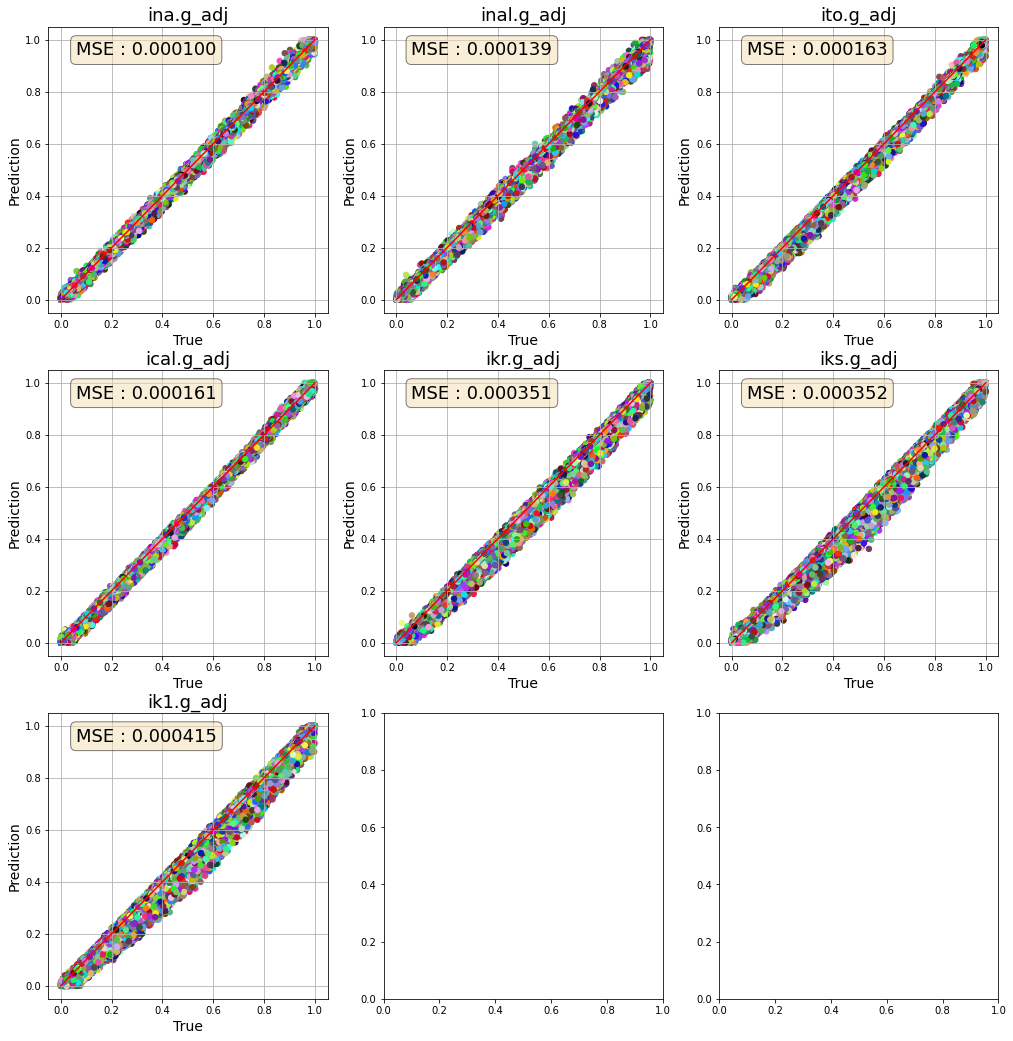

In [19]:
import matplotlib.cm as cm 
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
param_names = ['g', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
# colors = cm.rainbow(np.linspace(0, 1, len(cell_li)))

np.random.seed(2)
colors = np.random.rand(targets.shape[0], 3)

# Marker size in units of points^2

# close = 0.003 * price_data.close[:-2] / 0.003 * price_data.open[:-2]

for i in range(3):        
    for j in range(3):           
        if i==2 and j>0:
            continue
#             ax[i, j].set_xlim(-range_crit, range_crit)
#             ax[i, j].set_ylim(-range_crit, range_crit)  
        index = i*3 + j
        title = G_adj_li[index]
        x = targets[:, index]
        y = final_results[:, index]
        mse = mse_results[index]
        
        ax[i, j].set_title( "%s"%(title), fontsize=18)           
        ax[i, j].plot([0, 1], [0, 1], c='r')
        ax[i, j].scatter(x, y, label="", c=colors, s=30)            
        ax[i, j].set_xlabel( 'True', fontsize=14)
        ax[i, j].set_ylabel( "Prediction", fontsize=14)        
#         ax[i, j].legend()
        ax[i, j].grid(True)  
            
        textstr = "MSE : %f"%(mse)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)        
        ax[i, j].text(0.1, 0.95, textstr, transform=ax[i, j].transAxes, fontsize=18, verticalalignment='top', bbox=props)    
# plt.colorbar(label='color')
# fig.suptitle("Parameter estimation")
# fig1 = plt.gcf()
# plt.tight_layout()
plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.2, hspace=0.2)
plt.savefig( os.path.join(output_dir1, 'results1.jpg'), dpi=199) 
plt.show()

In [20]:
print("Finish")

Finish
